In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib import cm, ticker
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.discriminative_models import LogisticRegression
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.optimizers.ppcef import PPCEF

In [3]:
def plot_model_distribution(model, median_prob=None, disc_model=None):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20,12)

    xline = torch.linspace(-1.5, 2.5, 200)
    yline = torch.linspace(-.75, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)
    
    with torch.no_grad():
        zgrid0 = model(xyinput, torch.zeros(40000, 1)).exp().reshape(200, 200)
        zgrid1 = model(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)

    zgrid0 = zgrid0.numpy()
    zgrid1 = zgrid1.numpy()

    if median_prob is not None:
        median_prob = np.exp(median_prob)
        cs1_mp = ax.contourf(xgrid.numpy(), ygrid.numpy(), zgrid1, levels=[median_prob, median_prob+10.00], alpha = 0.1, colors='#DC143C') 

    cs0 = ax.contour(xgrid.numpy(), ygrid.numpy(), zgrid0, levels=10, cmap='Greys', linewidths=0.4, antialiased=True)
    cs1 = ax.contour(xgrid.numpy(), ygrid.numpy(), zgrid1, levels=10, cmap='Oranges', linewidths=0.4, antialiased=True)
    return ax

In [4]:
dataset = MoonsDataset(file_path="../data/moons.csv")

disc_model = LogisticRegression(input_size=2, target_size=1)
disc_model.load("../models/MoonsDataset/disc_model_LogisticRegression.pt")

flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
flow.load("../models/MoonsDataset/gen_model_MaskedAutoregressiveFlow.pt")

cf = PPCEF(
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)

In [5]:
median_prob = cf.calculate_median_log_prob(dataset.train_dataloader(batch_size=64, shuffle=False))
median_prob

-0.13134873

In [6]:
"""Sparsemax activation function.

Pytorch implementation of Sparsemax function from:
-- "From Softmax to Sparsemax: A Sparse Model of Attention and Multi-Label Classification"
-- André F. T. Martins, Ramón Fernandez Astudillo (http://arxiv.org/abs/1602.02068)
"""

from __future__ import division

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.

        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size

        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor

        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

In [7]:
class PPCEF_2(torch.nn.Module):
    def __init__(self, N, D, K):
        super(PPCEF_2, self).__init__()
        assert K == N, "Assumption of the method!"
        assert N >= 1
        assert D >= 1
        
        self.N = N
        self.D = D
        self.K = K
        
        self.d = torch.nn.Parameter(torch.zeros((N, D)))

    def forward(self, X):
        return X + self.d

    def get_matrices(self):
        return torch.ones(self.N, 1), torch.ones(self.N, self.K), self.d


class AReS(torch.nn.Module):
    def __init__(self, N, D, K=1):
        super(AReS, self).__init__()
        assert K == 1, "Assumption of the method!"
        assert N >= 1
        assert D >= 1
        
        self.N = N
        self.D = D
        self.K = K
        
        self.d = torch.nn.Parameter(torch.zeros(self.K, self.D))

    def forward(self, X):
        return X + torch.ones(self.N, self.K) @ self.d

    def get_matrices(self):
        return torch.ones(self.N, 1), torch.ones(self.N, self.K), self.d


class GLOBAL_CE(torch.nn.Module):
    def __init__(self, N, D, K):
        super(GLOBAL_CE, self).__init__()
        assert K == 1, "Assumption of the method!"
        assert N >= 1
        assert D >= 1
        
        self.N = N
        self.D = D
        self.K = K

        self.m = torch.nn.Parameter(torch.zeros(self.N, 1))
        self.d = torch.nn.Parameter(torch.zeros((self.K, self.D)))

    def forward(self, X):
        return X + torch.exp(self.m) @ self.d

    def get_matrices(self):
        return torch.exp(self.m), torch.ones(self.N, self.K), self.d


class Ours(torch.nn.Module):
    def __init__(self, N, D, K):
        super(Ours, self).__init__()
        assert 1 <= K and K <= N, "Assumption of the method!"
        assert N >= 1
        assert D >= 1
        
        self.N = N
        self.D = D
        self.K = K

        self.m = torch.nn.Parameter(torch.zeros(self.N, 1))
        self.s = torch.nn.Parameter(0.01 * torch.rand(self.N, self.K))
        self.d = torch.nn.Parameter(torch.zeros((self.K, self.D)))

        self.sparsemax = Sparsemax(dim=1)

    def forward(self, X):
        return X + torch.exp(self.m) * self.sparsemax(self.s) @ self.d

    def get_matrices(self):
        return torch.exp(self.m), self.sparsemax(self.s), self.d



# method = PPCEF_2(N=3, D=2, K=3)
# M, S, D = method.get_matrices()

# M * S @ D


# method = AReS(N=3, D=2, K=1)
# M, S, D = method.get_matrices()

# M * S @ D


# method = GLOBAL_CE(N=3, D=2, K=1)
# M, S, D = method.get_matrices()

# M * S @ D


# method = Ours(N=3, D=2, K=1)
# M, S, D = method.get_matrices()

# M * S @ D

In [8]:
def entropy_loss(prob_dist):
    prob_dist = torch.clamp(prob_dist, min=1e-9)
    row_wise_entropy = -torch.sum(prob_dist * torch.log(prob_dist), dim=1)
    return row_wise_entropy



x_origin = torch.tensor(
    [
        [-0.6,  0.8],
        [-0.6,  1.0],
        [ 0.4,  0.4]
    ], 
    requires_grad=False
)


N = x_origin.shape[0]
D = x_origin.shape[1]
K = 3


context_origin = torch.tile(torch.Tensor([0]), dims = (N, 1))
context_target = torch.tile(torch.Tensor([1]), dims = (N, 1))


blcf = Ours(N, D, K)

optimizer = torch.optim.Adam(blcf.parameters(), lr=0.005)
min_loss = np.inf
no_improve = 0

num_iterations = 2000
patience = 100
alpha = 10
# lamda = 1

p_history = []
p_history.append(x_origin.detach().numpy().copy())

pbar = tqdm(range(num_iterations))

for i in pbar:
    optimizer.zero_grad()
    x_prim = blcf(x_origin)
    
    loss_components = cf.search_step(x_prim, x_origin, context_origin, context_target, alpha=alpha, delta=median_prob)
    mean_loss = (loss_components["dist"].reshape(-1, 1) + alpha * loss_components["loss_disc"]).mean()
    # mean_loss = loss_components["loss"].mean()
    mean_loss += 100 * entropy_loss(blcf.sparsemax(blcf.s)).mean() # Entropy Loss to enforce class assignment!
    pbar.set_description(f"Loss: {mean_loss}")
    
    mean_loss.backward()
    optimizer.step()

    if mean_loss.item() < min_loss:
        min_loss = mean_loss.item()
    else:
        no_improve += 1
    if no_improve > patience:
        p_history.append(x_prim.detach().numpy().copy())
        break

    if i % 10 == 0:
        p_history.append(x_prim.detach().numpy().copy())

p_history = np.concatenate(p_history)

Loss: 0.853662371635437:  16%|████████████████████████████▉                                                                                                                                                           | 314/2000 [00:01<00:08, 197.61it/s]


In [9]:
# entropy_loss(blcf.sparsemax(blcf.s).sum(axis=0) / blcf.sparsemax(blcf.s).sum())
# Entropy Loss to enforce the smallest possible amount of components.

In [10]:
loss_components

{'loss': tensor([[  8.6434,   1.2606, 119.3606],
         [  8.6434,   1.2606, 119.3606],
         [  8.6434,   1.2606, 119.3606]], grad_fn=<AddBackward0>),
 'dist': tensor([1.0896, 1.2606, 0.2108], grad_fn=<LinalgVectorNormBackward0>),
 'max_inner': tensor([ 0.7554,  0.0000, 11.9150], grad_fn=<ReluBackward0>),
 'loss_disc': tensor([[0.],
         [0.],
         [0.]], grad_fn=<ReluBackward0>)}

In [11]:
blcf.get_matrices()

(tensor([[1.6126],
         [1.8637],
         [1.0351]], grad_fn=<ExpBackward0>),
 tensor([[0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 1.]], grad_fn=<TransposeBackward0>),
 Parameter containing:
 tensor([[ 0.3042, -0.4222],
         [ 0.3818, -0.5582],
         [ 0.1106, -0.1714]], requires_grad=True))

In [12]:
disc_model(x_origin), disc_model(x_prim)

(tensor([[0.1147],
         [0.0854],
         [0.4184]], grad_fn=<SigmoidBackward0>),
 tensor([[0.5204],
         [0.5218],
         [0.5205]], grad_fn=<SigmoidBackward0>))

/opt/homebrew/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


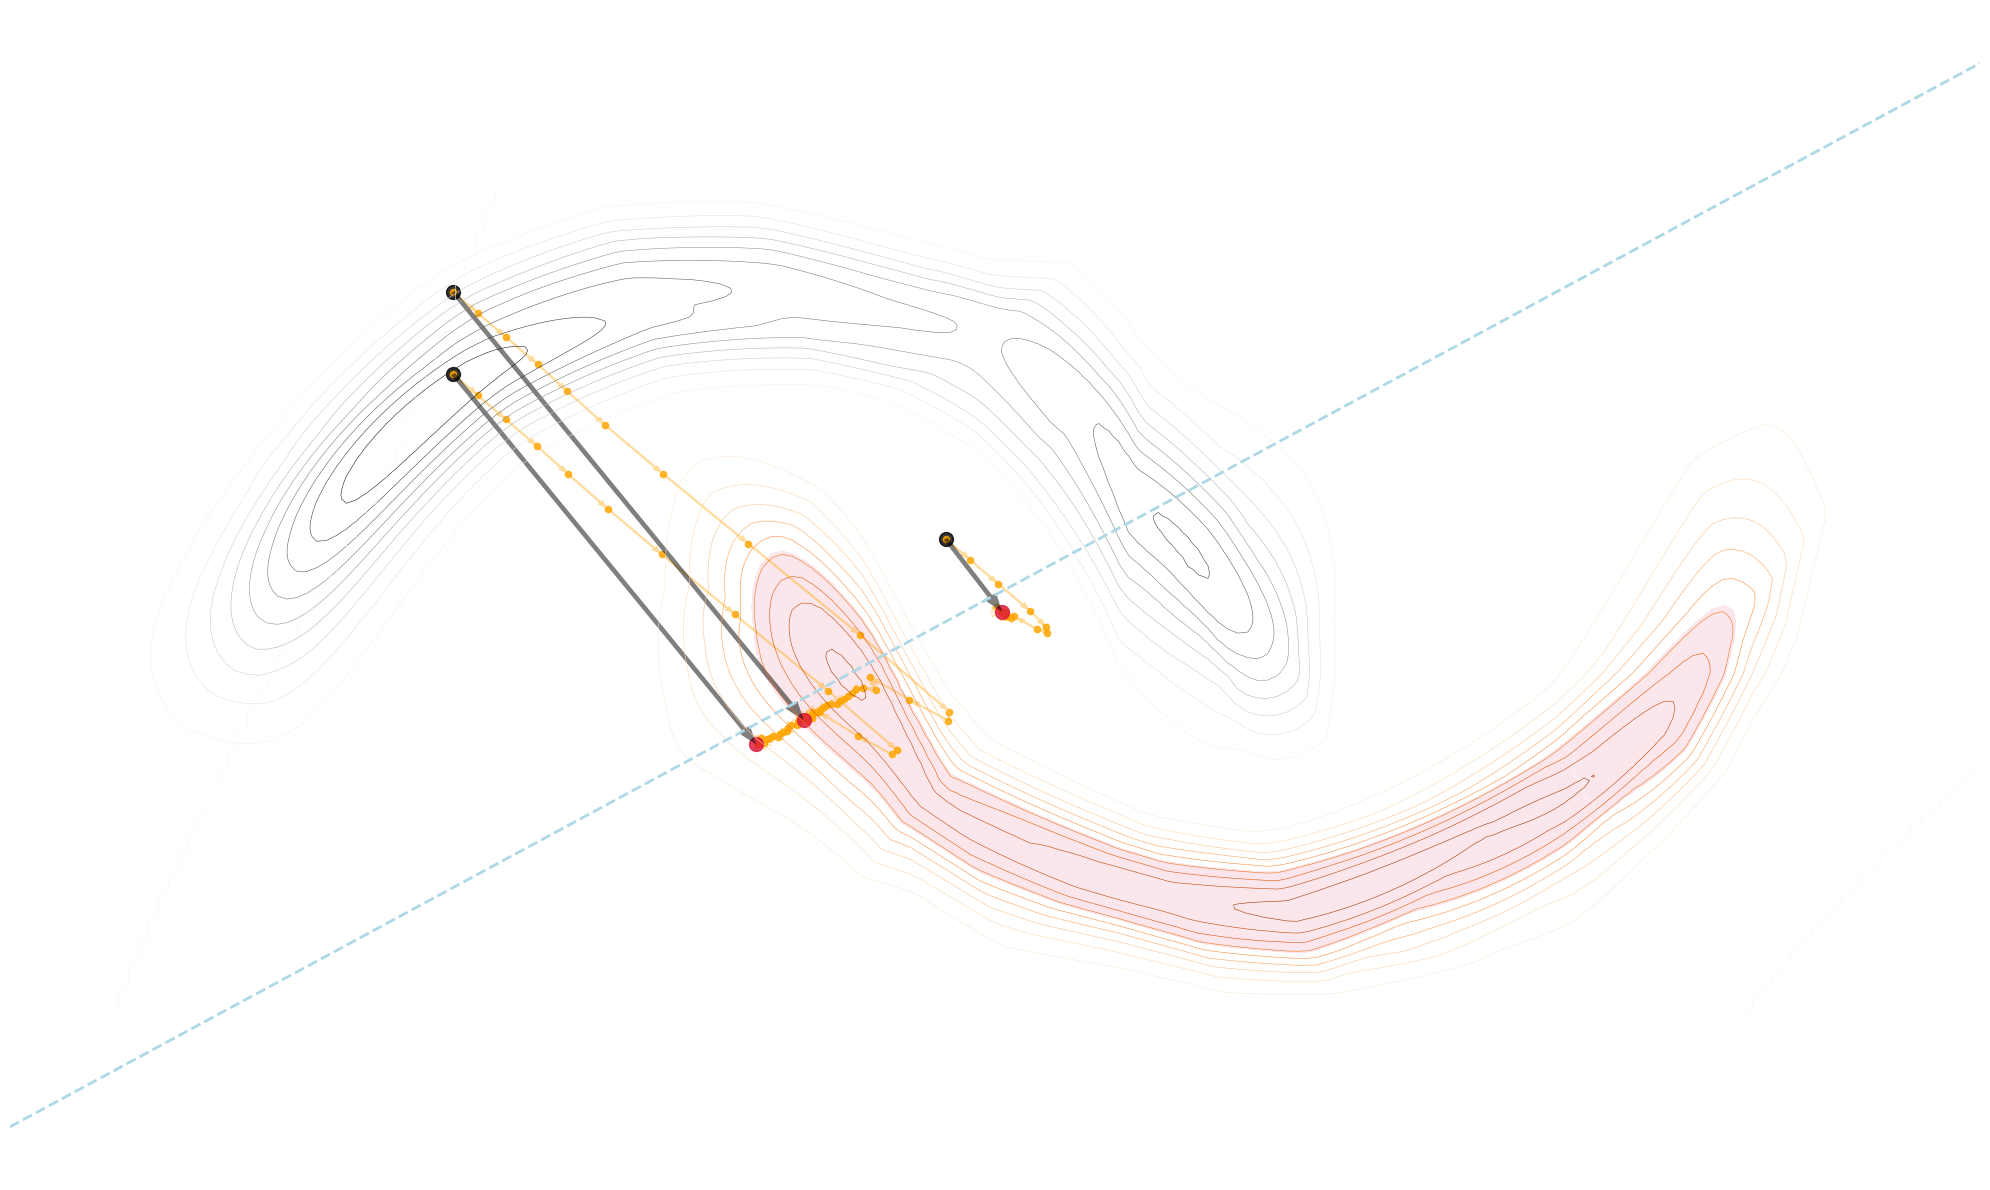

In [13]:
## Distribution Plot
ax = plot_model_distribution(cf.gen_model, median_prob, cf.disc_model)

## Classifier Line
w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
c = -b/w2
m = -w1/w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, '#ADD8E6', lw=2.0, ls="dashed")
plt.axis("off")

for n in range(N):
    p_hist = p_history[n::N]
    ## Arrows
    for i in range(p_hist.shape[0]-1):
        ax.arrow(p_hist[i, 0], p_hist[i, 1], p_hist[i+1, 0]-p_hist[i, 0], p_hist[i+1, 1]-p_hist[i, 1], width=0.005, lw=0.001, length_includes_head=True, alpha=0.4, color="orange")
    
    ax.scatter(p_hist[0:1, 0], p_hist[0:1, 1], c="k", s=100, alpha=0.8)
    ax.scatter(p_hist[1:-1, 0], p_hist[1:-1, 1], c="orange", s=20, alpha=0.8)
    ax.scatter(p_hist[-1:, 0], p_hist[-1:, 1], c="#DC143C", s=100, alpha=0.8)
    ax.arrow(p_hist[0, 0], p_hist[0, 1], p_hist[-1, 0]-p_hist[0, 0], p_hist[-1, 1]-p_hist[0, 1], width=0.01, lw=0.001, length_includes_head=True, alpha=0.5, color="k")
    _ = ax.axis("off")
    
## Save Figure
plt.tight_layout()
# plt.savefig('Ours_Dist.pdf')